In [111]:
import utils
import whittaker_smooth as ws
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm


Text(0.5, 1.0, 'Q-Q plot (raw)')

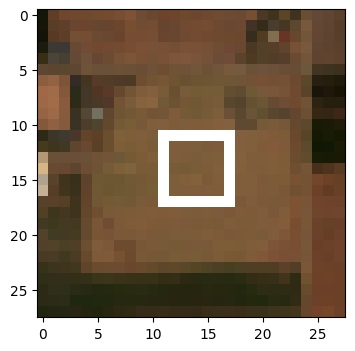

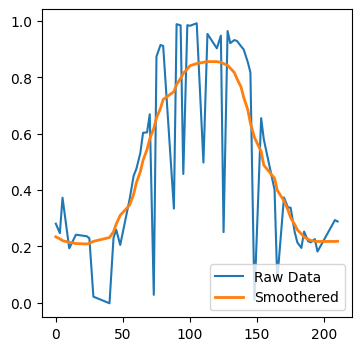

<Figure size 400x400 with 0 Axes>

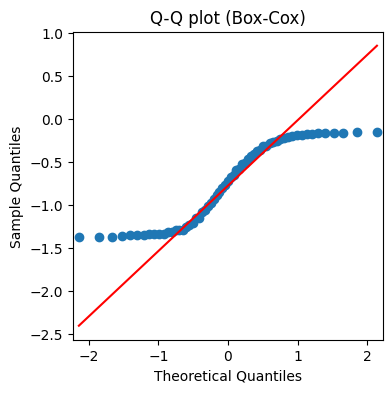

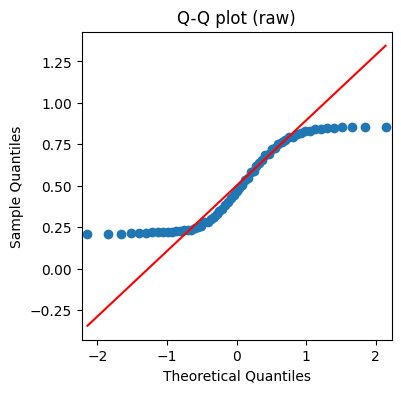

In [116]:
plt.rcParams['figure.figsize'] = [4,4]

#Loading Data
year = "2020"
IMGS_PATH = ('D:\VSCode\Repositorios\Plant-Growth-Cycle-based-on-geospatial-data-1\DataExtraction\DataBase\Kansas-'+year)
band_labels = ["B4", "B3", "B2", "B8"]
images = utils.load_landsat_image(IMGS_PATH, band_labels)
img_keys = list(images.keys())
days,dates = utils.dates_to_day_numbers(img_keys)

#Calculations

##NDVI
ndvi_ts = utils.generate_ndvi_time_series(images=images)
##NDVI curve smoothing
cleany = ws.whittaker_smooth(np.array(ndvi_ts),lmbd=200,d=2)

##Boxcox Transformation
fitted_data, fitted_lambda = stats.boxcox(cleany)

##Plotting 
plt.figure()
plt.plot(days,ndvi_ts,label="Raw Data") 
plt.plot(days,cleany,linewidth=2,label="Whittaker Smooth")
#plt.plot(fitted_data,label="Box-Cox")
plt.legend()

#Q-Q plot
plt.figure()
fig = sm.qqplot(np.array(fitted_data),dist=stats.norm,line="q")
plt.title("Q-Q plot (Box-Cox)")
fig2 = sm.qqplot(np.array(cleany),dist=stats.norm,line="q")
plt.title("Q-Q plot (raw)")




Lambda value used for Transformation: 0.23366398986091708


C:\Users\ricar\AppData\Local\Temp\ipykernel_13588\750647146.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(original_data, hist = False, kde = True,
d:\Python\lib\site-packages\seaborn\distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
C:\Users\ricar\AppData\Local\Temp\ipykernel_13588\750647146.py:27: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a fig

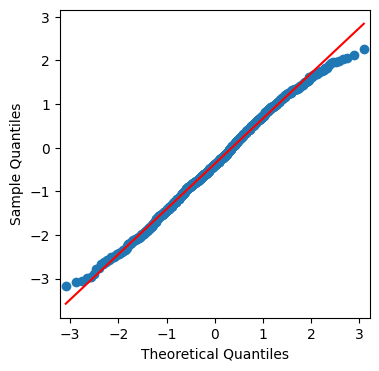

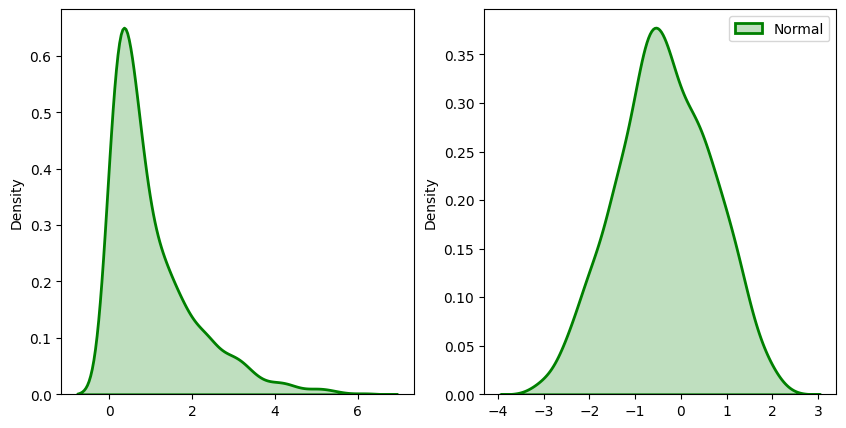

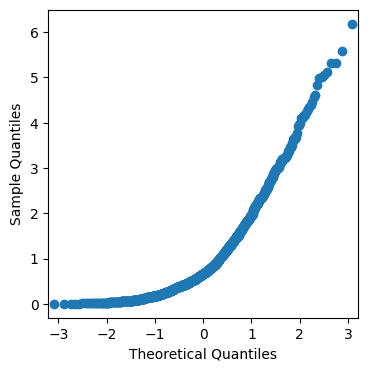

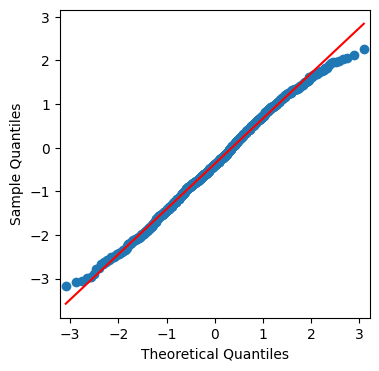

In [113]:
# Python3 code to show Box-cox Transformation
# of non-normal data

## EJEMPLO DE BOX COX
# import modules
import numpy as np
from scipy import stats

# plotting modules
import seaborn as sns
import matplotlib.pyplot as plt

# generate non-normal data (exponential)
original_data = np.random.exponential(size = 1000)

# transform training data & save lambda value
fitted_data, fitted_lambda = stats.boxcox(original_data)

# creating axes to draw plots
fig, ax = plt.subplots(1, 2)

# plotting the original data(non-normal) and
# fitted data (normal)
sns.distplot(original_data, hist = False, kde = True,
			kde_kws = {'shade': True, 'linewidth': 2},
			label = "Non-Normal", color ="green", ax = ax[0])

sns.distplot(fitted_data, hist = False, kde = True,
			kde_kws = {'shade': True, 'linewidth': 2},
			label = "Normal", color ="green", ax = ax[1])

# adding legends to the subplots
plt.legend(loc = "upper right")

# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(10)

print(f"Lambda value used for Transformation: {fitted_lambda}")

sm.qqplot(original_data)
sm.qqplot(fitted_data,line="r")
